# Merge the prophage predictions with RAST metadata

Combine RAST metadata and prophage predictions

In [52]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from PhiSpyAnalysis import theils_u, DateConverter

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

# for parsing collection dates
from dateutil.parser import parse, ParserError
import pytz

import subprocess
import gzip


In [3]:
# this is a neat trick for getting markdown in our output
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color="black"):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

# Read the phage data. Check the version!

We have two data sets: `small` is just 99 genomes and 1,561 phages and should run quickly for development. `not small` is all the data!

In [4]:
use_small_data = False

In [5]:
if use_small_data:
    phagesdf = pd.read_csv("../small_data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    phagesdf = pd.read_csv("../data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
githash = subprocess.check_output(["git", "describe", "--always"]).strip().decode()
print(f"Please note that this was run with git commit {githash} that has {phagesdf.shape[0]:,} genomes parsed and {phagesdf['Total Predicted Prophages'].sum():,} total prophages")

Please note that this was run with git commit 64eadd9 that has 553,082 genomes parsed and 20,946,107 total prophages


### Read the data file

The metadata is from PATRIC. The phage data is from us.

**NOTE:** Some of the PATRIC data refers to specific chromosomes/fragments in the GenBank file (e.g. plasmid, chromosome), but that may not equate to our predictions, because we have used the whole GenBank file. The PATRIC metadata is redundant for many fields, and so we just keep the first entry for each NCBI Assembly.

In [6]:
if use_small_data:
    metadf = pd.read_csv("../small_data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    metadf = pd.read_csv("../data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
dc = DateConverter()
metadf['isolation_date'] = metadf.collection_date.apply(dc.convert_date)

/home/redwards/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,6,7,8,9,10,11,12,14,19,21,34,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,65) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Filter for only the first of each genome assembly

    The metadata contains multiple entries for a genome assembly if it is submitted more than once, so here we just filter for the first instance. We might think about something smarter,  but this seems to work

In [7]:
metadf = metadf.groupby('assembly_accession').first().reset_index()

## Clean up the data

These are specific things in the data that we need to clean/replace. Add things here as you find them!

In [8]:
metadf['isolation_country'] = metadf['isolation_country'].replace('USA', 'United States')
metadf['isolation_country'] = metadf['isolation_country'].replace('Ecully', 'France')
metadf['geographic_location'] = metadf['geographic_location'].replace('USA', 'United States')
metadf['isolation_country'] = metadf['isolation_country'].replace('Adriatic Sea coasts', 'Adriatic Sea')
metadf['isolation_country'] = metadf['isolation_country'].replace('Côte', "Cote d'Ivoire")
metadf['isolation_country'] = metadf['isolation_country'].replace('" Azores"', 'Azores')
metadf['isolation_country'] = metadf['isolation_country'].replace('Democratic Republic of the Congo (Kinshasa)', 'Democratic Republic of the Congo')
metadf['isolation_country'] = metadf['isolation_country'].replace('Hong kong', 'Hong Kong')
metadf['isolation_country'] = metadf['isolation_country'].replace(' Republic of Korea', 'Republic of Korea')
metadf['isolation_country'] = metadf['isolation_country'].replace('Soviet Union', 'USSR')
metadf['isolation_country'] = metadf['isolation_country'].replace('Vietnam', 'Viet Nam')

# Finally replace all None with np.nan
metadf = metadf.fillna(value=np.nan)

# Categorical Correlations

Are any of our categories correlated? This uses Theil's Uncertainty to measure the correlation between the categories.

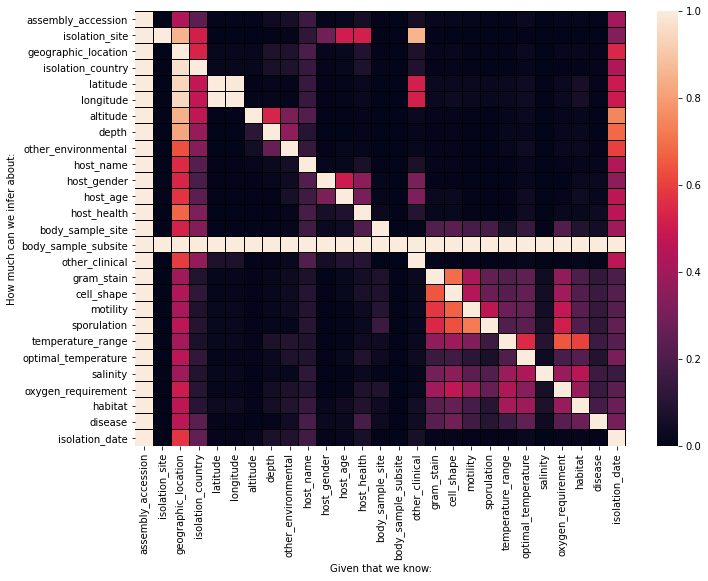

In [9]:
acccol = 'assembly_accession'
interesting_cols = [acccol, 'isolation_site', 'geographic_location', 'isolation_country', 'latitude', 'longitude', 'altitude', 'depth',
                    'other_environmental', 'host_name', 'host_gender', 'host_age', 'host_health', 
                    'body_sample_site', 'body_sample_subsite', 'other_clinical', 'gram_stain', 'cell_shape',
                    'motility', 'sporulation', 'temperature_range', 'optimal_temperature', 'salinity',
                    'oxygen_requirement', 'habitat', 'disease', 'isolation_date']

hmi = pd.DataFrame(index=interesting_cols, columns=interesting_cols, dtype=float)
for i,j in enumerate(interesting_cols):
    for x,y in enumerate(interesting_cols):
        hmi.iloc[i,x] = theils_u(metadf.loc[:,j], metadf.loc[:,y])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
# sns.heatmap(hmi, cmap='Blues', ax=ax)
ax = sns.heatmap(hmi, linecolor='k', linewidths=0.01, ax=ax)
t = ax.set_ylabel("How much can we infer about:")
t = ax.set_xlabel("Given that we know:")

In [50]:
printmd(f"**Fig. S\*\***. Conditional categorical correlations of variables. Theil's Uncertainty was used to compare the correlations between variables. The colour in each cell represents the relationship between the category along the x-axis and the category along the y-axis. Thus knowing each category on the x-axis provides different information about categories on the y-axis. Note that _body_sample_subsite_ is always NULL and thus everything can predict that. There is a relationship between the geographic categories (_geographic location_, _isolation country_, _latitude_, _longitude_, _altitude_, and _depth_)")

<span style='color:black'>**Fig. S\*\***. Conditional categorical correlations of variables. Theil's Uncertainty was used to compare the correlations between variables. The colour in each cell represents the relationship between the category along the x-axis and the category along the y-axis. Thus knowing each category on the x-axis provides different information about categories on the y-axis. Note that _body_sample_subsite_ is always NULL and thus everything can predict that. There is a relationship between the geographic categories (_geographic location_, _isolation country_, _latitude_, _longtitude_, _altitude_, and _depth_)</span>

###### This is hard to understand!

I know, its a conditional probability. Here are two examples to help

In [11]:
col1 = 'other_clinical'
col2 = 'isolation_site'
u1 = theils_u(metadf.loc[:,col1], metadf.loc[:,col2])
u2 = theils_u(metadf.loc[:,col2], metadf.loc[:,col1])

print(f"{col1} vs {col2} {u1}")
print(f"{col2} vs {col1} {u2}")

if u1 > u2:
    print("Theils U is probability of X given Y")
    print(f"This means that knowing the {col2} we have a lot of information about the {col1} ")
    print(f"but knowing the {col1} does not inform us about the {col2}")
else:
    print("Theils U is probability of X given Y")
    print(f"This means that knowing the {col1} we have a lot of information about the {col2} ")
    print(f"but knowing the {col2} does not inform us about the {col1}")

printmd("For example, lets look at the data for Sputum. Does it predict _other\_clinical_?")
print(metadf[metadf['isolation_site'] == 'Sputum'].groupby(['other_clinical', 'isolation_site']).size().reset_index(name='Count'))

other_clinical vs isolation_site 0.005078095497709224
isolation_site vs other_clinical 0.8588933773243432
Theils U is probability of X given Y
This means that knowing the other_clinical we have a lot of information about the isolation_site 
but knowing the isolation_site does not inform us about the other_clinical


<span style='color:black'>For example, lets look at the data for Sputum. Does it predict _other\_clinical_?</span>

                                      other_clinical isolation_site  Count
0      comorbidity:HIV negative;treatment course:adm         Sputum     39
1      comorbidity:HIV positive;treatment course:adm         Sputum     15
2  comorbidity:MDR-TB, HIV negative;treatment cou...         Sputum     25
3  comorbidity:MDR-TB, HIV positive;treatment cou...         Sputum      2
4  comorbidity:MDR_TB, HIV negative;treatment cou...         Sputum      1
5                          hospital location:non-ICU         Sputum      1
6                               treatment course:adm         Sputum      1


#### Example 2: geographic location vs. isolation country

In [12]:
col1 = 'geographic_location'
col2 = 'isolation_country'
counts12 = {}
counts21 = {}
for index, row in metadf.iterrows():
    gl = row[col1]
    ic = row[col2]
    
    if gl not in counts12:
        counts12[gl] = {}
    counts12[gl][ic] = counts12[gl].get(ic, 0) + 1
    
    if ic not in counts21:
        counts21[ic] = {}
    counts21[ic][gl] = counts21[ic].get(gl, 0) + 1

c12s = 0
c12m = 0
c21s = 0
c21m = 0
for k in counts12:
    if len(counts12[k]) == 1:
        c12s += 1
    else:
        c12m += 1

for k in counts21:
    if len(counts21[k]) == 1:
        c21s += 1
    else:
        c21m += 1

print(f"Given {len(counts12.keys()):,} {col1} you will have {c12s:,} ({c12s/len(counts12.keys())*100:.2f} %) single {col2}")
print(f"Given {len(counts12.keys()):,} {col1} you will have {c12m:,} ({c12m/len(counts12.keys())*100:.2f} %) multiple {col2}")
print(f"\nGiven {len(counts21.keys()):,} {col2} you will have {c21s:,} ({c21s/len(counts21.keys())*100:.2f} %) single {col1}")
print(f"Given {len(counts21.keys()):,} {col2} you will have {c21m:,} ({c21m/len(counts21.keys())*100:.2f} %) multiple {col1}")

Given 13,967 geographic_location you will have 13,817 (98.93 %) single isolation_country
Given 13,967 geographic_location you will have 150 (1.07 %) multiple isolation_country

Given 281 isolation_country you will have 77 (27.40 %) single geographic_location
Given 281 isolation_country you will have 204 (72.60 %) multiple geographic_location


#### Drop Geographic Location

This is just a proxy for `isolation_country` and we don't want it duplicated.

In [13]:
metadf['geographic_location'] = metadf['geographic_location'].replace('USA', 'United States')
metadf[
    (metadf['geographic_location'].notnull()) &
    (metadf['isolation_country'].notnull()) & 
    (metadf['geographic_location'] != metadf['isolation_country'])
][['isolation_country', 'geographic_location']]

,isolation_country,geographic_location
1,Canada,Canada: Quebec
5,United States,New York State
7,United States,"West Palm Beach, Florida"
10,Denmark,Denmark: Aarhus
22,Norway,"Kongsvinger, Norway"
...,...,...
320148,United Kingdom,"United Kingdom:London, United Kingdom"
320149,United Kingdom,"United Kingdom:Scotland, UK"
320163,United States,"USA:Muskegon County, MI"
320164,Slovenia,Slovenia: Pragersko


In [14]:
metadf = metadf.drop('geographic_location', axis=1)

## Read our categories

This is the data from Laura

In [15]:
catdf = pd.read_csv("../data/categories.tsv.gz", compression='gzip', header=0, delimiter="\t")
if 'gbff' in catdf:
    catdf = catdf.drop('gbff', axis=1)
catdf = catdf.groupby('assembly_accession').first().reset_index()
catdf

,assembly_accession,Category
0,GCA_000003645.1,food
1,GCA_000003925.1,soil
2,GCA_000003955.1,human blood
3,GCA_000005825.2,soil
4,GCA_000006155.2,human other
...,...,...
54640,GCA_902860175.1,built environment
54641,GCA_902860185.1,human other
54642,GCA_902860195.1,human other
54643,GCA_902860235.1,plant


### Make sure we have the right column

PATRIC calls the column `assembly_accession` while GTDB calls it `ncbi_genbank_assembly_accession`

In [16]:
acccol = 'assembly_accession'
metadf[acccol]

0         GCA_000003135.1
1         GCA_000003215.1
2         GCA_000003645.1
3         GCA_000003925.1
4         GCA_000003955.1
               ...       
320171    GCF_900167595.1
320172    GCF_900167605.1
320173    GCF_900167615.1
320174    GCF_900167625.1
320175    GCF_900167635.1
Name: assembly_accession, Length: 320176, dtype: object

In [17]:
catdf[acccol]

0           GCA_000003645.1
1           GCA_000003925.1
2           GCA_000003955.1
3           GCA_000005825.2
4           GCA_000006155.2
                ...        
54640       GCA_902860175.1
54641       GCA_902860185.1
54642       GCA_902860195.1
54643       GCA_902860235.1
54644    assembly_accession
Name: assembly_accession, Length: 54645, dtype: object

### Abstract out the accession and name into new columns

This will allow us to merge the data with the PATRIC and GTDB data

In [18]:
def get_acc_name(x):
    regexp = re.compile('(\w+\.\d+)_([\w\.\-]+)_genomic.gbff.gz')
    m = regexp.match(x)
    if not m:
        sys.stderr.write(f"WARNING: Regexp did not match {x}\n")
        return (None, None)
    return list(m.groups())

phagesdf = pd.concat([pd.DataFrame.from_records(phagesdf['Contig'].apply(get_acc_name), columns=[acccol, 'Name']), phagesdf], axis=1)
phagesdf

,assembly_accession,Name,Contig,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1,ASM313v1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,114,10,16,2,1,13,48916
1,GCA_000003645.1,ASM364v1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,1,31,1,10,20,40297
2,GCA_000003925.1,ASM392v1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,1,38,6,13,19,268081
3,GCA_000003955.1,ASM395v1,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,1,46,6,11,29,166286
4,GCA_000005825.2,ASM582v2,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,3,33,3,9,21,93416
...,...,...,...,...,...,...,...,...,...,...,...
553077,GCA_902860175.1,LMG_5997,GCA_902860175.1_LMG_5997_genomic.gbff.gz,7197255,38,21,33,2,14,17,69051
553078,GCA_902860185.1,LMG_6103,GCA_902860185.1_LMG_6103_genomic.gbff.gz,6497464,13,8,22,0,10,12,0
553079,GCA_902860195.1,LMG_7053,GCA_902860195.1_LMG_7053_genomic.gbff.gz,6702936,200,148,33,1,11,21,12819
553080,GCA_902860205.1,LMG_6001,GCA_902860205.1_LMG_6001_genomic.gbff.gz,6320373,36,19,35,2,21,12,41572


### Merge the dataframes

First, select some columns we want to keep from PATRIC, and then merge the data frames. We write this to a tsv file for Laura to append isolation information to.

In [35]:
interesting_cols = [acccol, 'isolation_site', 'isolation_country', 'latitude', 'longitude', 'altitude', 'depth',
                    'other_environmental', 'host_name', 'host_gender', 'host_age', 'host_health', 
                    'body_sample_site', 'body_sample_subsite', 'other_clinical', 'gram_stain', 'cell_shape',
                    'motility', 'sporulation', 'temperature_range', 'optimal_temperature', 'salinity',
                    'oxygen_requirement', 'habitat', 'disease', 'isolation_date']

few_interesting_cols = [acccol,  'isolation_country',  'gram_stain',  
                    'motility', 'sporulation', 'temperature_range', 'habitat', 'disease', 'isolation_date']


tempdf = metadf[interesting_cols]
# tempdf = metadf[few_interesting_cols]
temp1 = pd.merge(tempdf, catdf, how='left', left_on=acccol, right_on=acccol)
# phagemeta = pd.merge(tempdf, phagesdf, how='inner', left_on=acccol, right_on=acccol)
# phagemeta.to_csv(os.path.join('results', 'example_isolations.tsv'), sep='\t')

phagemeta = pd.merge(temp1, phagesdf, how='right', left_on=acccol, right_on=acccol)


# Define the columns

These are for the columns we are going to use

In [36]:
begdata = 1 # ignore the first column which is the assembly name
# enddata = 9 # this is if we are using a smaller dataset
enddata = 27 # this is all the metadata
phagemeta.iloc[:,begdata:enddata]

,isolation_site,isolation_country,latitude,longitude,altitude,depth,other_environmental,host_name,host_gender,host_age,...,motility,sporulation,temperature_range,optimal_temperature,salinity,oxygen_requirement,habitat,disease,isolation_date,Category
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Human, Homo sapiens",NaN,NaN,...,No,No,Mesophilic,-,NaN,Anaerobic,Host-associated,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Yes,Yes,Mesophilic,-,NaN,Aerobic,Multiple,Food poisoning,NaN,food
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,No,Yes,NaN,-,NaN,NaN,NaN,NaN,NaN,soil
3,NaN,Iceland,NaN,NaN,NaN,NaN,NaN,"Human, Homo sapiens",NaN,NaN,...,Yes,Yes,Mesophilic,-,NaN,Aerobic,Multiple,Food poisoning,NaN,human blood
4,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Yes,Yes,Mesophilic,-,NaN,Facultative,Terrestrial,NaN,NaN,soil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999.956879,built environment
553078,NaN,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999.956879,human other
553079,NaN,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999.956879,human other
553080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999.956879,NaN


## Sanity check

This is just to make sure that we are all working on the same data. Here, we make a temporary data frame that has the number of contigs and the number of basepairs in the genome, and use those to compare to see if we think we are working on the same thing.

This is tricky because PATRIC has duplicates in the data, thus `GCA_000005825.2` appears three times in the PATRIC metadata, twice for the plasmids and once for the assembly.

We can maybe merge on two fields:

```

comparison = pd.merge(metadf[[acccol, 'contigs', 'genome_length']],
                      phagesdf[[acccol, 'Name', 'Contigs', 'Genome length']],
                      how='right', left_on=[acccol, 'genome_length'], right_on=[acccol, 'Genome length'])
```

and then look for entries in phagesdf that are missing from the merged (or just use the entries in the merged throughout).

In [16]:
def are_same(x):
    # currently fixing contig counts, so when that is done delete the next line and uncomment the one after
    return x['genome_length'] == x['Genome length']
    # return x['genome_length'] == x['Genome length'] and x['contigs'] == x['Contigs']


comparison = pd.merge(metadf[[acccol, 'contigs', 'genome_length']],
                      phagesdf[[acccol, 'Name', 'Contigs', 'Genome length']],
                      how='right', left_on=acccol, right_on=acccol)

comparison['same'] = comparison.apply(are_same, axis=1)
# look for rows that are not the same
print(f"{comparison[comparison['same']==False].shape[0]:,} rows are not the same")
print(f"{comparison[comparison['same']==True].shape[0]:,} rows are the same")

444,503 rows are not the same
108,579 rows are the same


## How many NaNs are there?

In [17]:
for c in phagemeta.iloc[:,begdata:enddata].columns:
    print(f"{c}\t{phagemeta[phagemeta[c].notnull()].shape[0]}")

isolation_site	128
isolation_country	96876
latitude	2910
longitude	2909
altitude	1033
depth	8094
other_environmental	9841
host_name	59086
host_gender	4069
host_age	3610
host_health	11651
body_sample_site	2032
body_sample_subsite	0
other_clinical	11223
gram_stain	8097
cell_shape	7380
motility	5267
sporulation	3873
temperature_range	4015
optimal_temperature	10737
salinity	705
oxygen_requirement	6440
habitat	4344
disease	2096
isolation_date	90756
Category	54644


## Encode the data

This converts every column into categories so we can (hopefully) use it in the RF models

In [18]:
pmenc = pd.DataFrame()
for c in phagemeta.iloc[:,begdata:enddata].columns:
    pmenc[c] = phagemeta[c].astype('category').cat.codes
pmenc['isolation_date'] = phagemeta['isolation_date'].fillna(-1)
pmenc.sort_values('isolation_date')

,isolation_site,isolation_country,latitude,longitude,altitude,depth,other_environmental,host_name,host_gender,host_age,...,motility,sporulation,temperature_range,optimal_temperature,salinity,oxygen_requirement,habitat,disease,isolation_date,Category
0,-1,-1,-1,-1,-1,-1,-1,1044,-1,-1,...,5,3,8,1,-1,3,14,-1,-1.000000,-1
357518,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.000000,-1
357517,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.000000,-1
357516,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.000000,-1
357515,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.000000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503278,-1,221,-1,-1,-1,104,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,2020.063655,46
503273,-1,221,-1,-1,-1,104,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,2020.063655,46
503279,-1,221,-1,-1,-1,104,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,2020.063655,46
503275,-1,221,-1,-1,-1,104,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,2020.063655,46


## Random Forest

Can we identify which features best predict the number of phages predicted. Note we should compare total/kept/etc

First, an RF with all the data. You might want to skip this!

In [53]:
x_train, x_test, y_train, y_test = train_test_split(pmenc['isolation_country'], phagemeta.Kept.values.ravel())
clf = RandomForestClassifier(random_state=42, n_estimators=1000, bootstrap=True, n_jobs=-1, oob_score=True)
rf = clf.fit(x_train.ravel().reshape(-1,1), y_train)
y_pred=clf.predict(x_test.ravel().reshape(-1,1))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
f1base = metrics.f1_score(y_test, y_pred, average='weighted')
print("f1: ", f1base)

Accuracy: 0.13039610619725034
f1:  0.05933156826731004


In [59]:
print(f"The boostrap choose {x_train.ravel().reshape(-1,1).shape[0]} samples at random")

The boostrap choose 414811 samples at random


## Important features

What are the most important features for predicting the number of prophages in a genome?

In [54]:
fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
# impdf['Number Not Null'] = phagemeta[phagemeta[impdf['feature']].notnull()].shape[0]
impdf

,feature,importance
0,isolation_site,1.0


In [55]:
def number_not_null(x):
    return phagemeta[phagemeta[x.feature].notnull()].shape[0]

fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
impdf["Number of observations"] = impdf.apply(number_not_null, axis=1)
impdf

,feature,importance,Number of observations
0,isolation_site,1.0,128


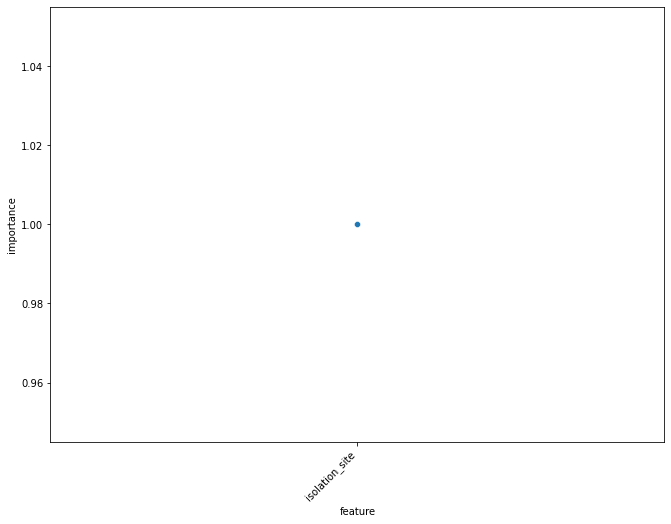

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='feature', y='importance', data=impdf, ax=ax)
plt.xticks(rotation=45,  horizontalalignment='right')
fig.savefig(f"images/rf_importance.svg")

In [57]:
printmd(f"**Fig. S\*\***. Variable importance plot for each of the {impdf.shape[0]} features tested by the random forest")

<span style='color:black'>**Fig. S\*\***. Variable importance plot for each of the 1 features tested by the random forest</span>

In [58]:
printmd("**Random Forest output**", "blue")
printmd(f"There were {rf.n_features_} _features_ (columns in the dataframe), and {rf.n_classes_} _classes_ (unique categories)")
printmd(f"The OOB error was {rf.oob_score_}")

<span style='color:blue'>**Random Forest output**</span>

<span style='color:black'>There were 1 _features_ (columns in the dataframe), and 58 _classes_ (unique categories)</span>

<span style='color:black'>The OOB error was 0.13133692211633732</span>

# Exploring the data

Lets take a look at some of these important things.

## Isolation date of the phage

Note that above we do a lot of work to create the `isolation_date` field, which is now the year of isolation as a decimal so that it plots out nicely! 


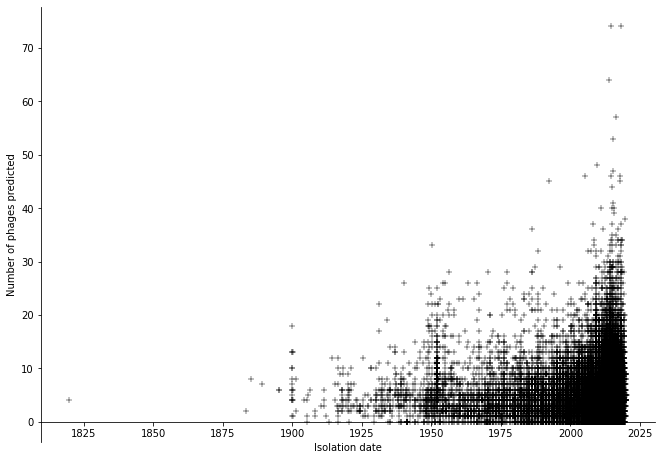

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='isolation_date', y='Kept', data=phagemeta[phagemeta['isolation_date'].notnull()], ax=ax, marker='+', color='k')
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation date")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


fig.savefig(f"images/phages_vs_ya.svg")

In [47]:
print(f"Fig. *** Number of prophages per genome for each of the {phagemeta[phagemeta['isolation_date'].notnull()].shape[0]:,} genomes for which the isolation date is known")

Fig. *** Number of prophages per genome for each of the 90,756 genomes for which the isolation date is known


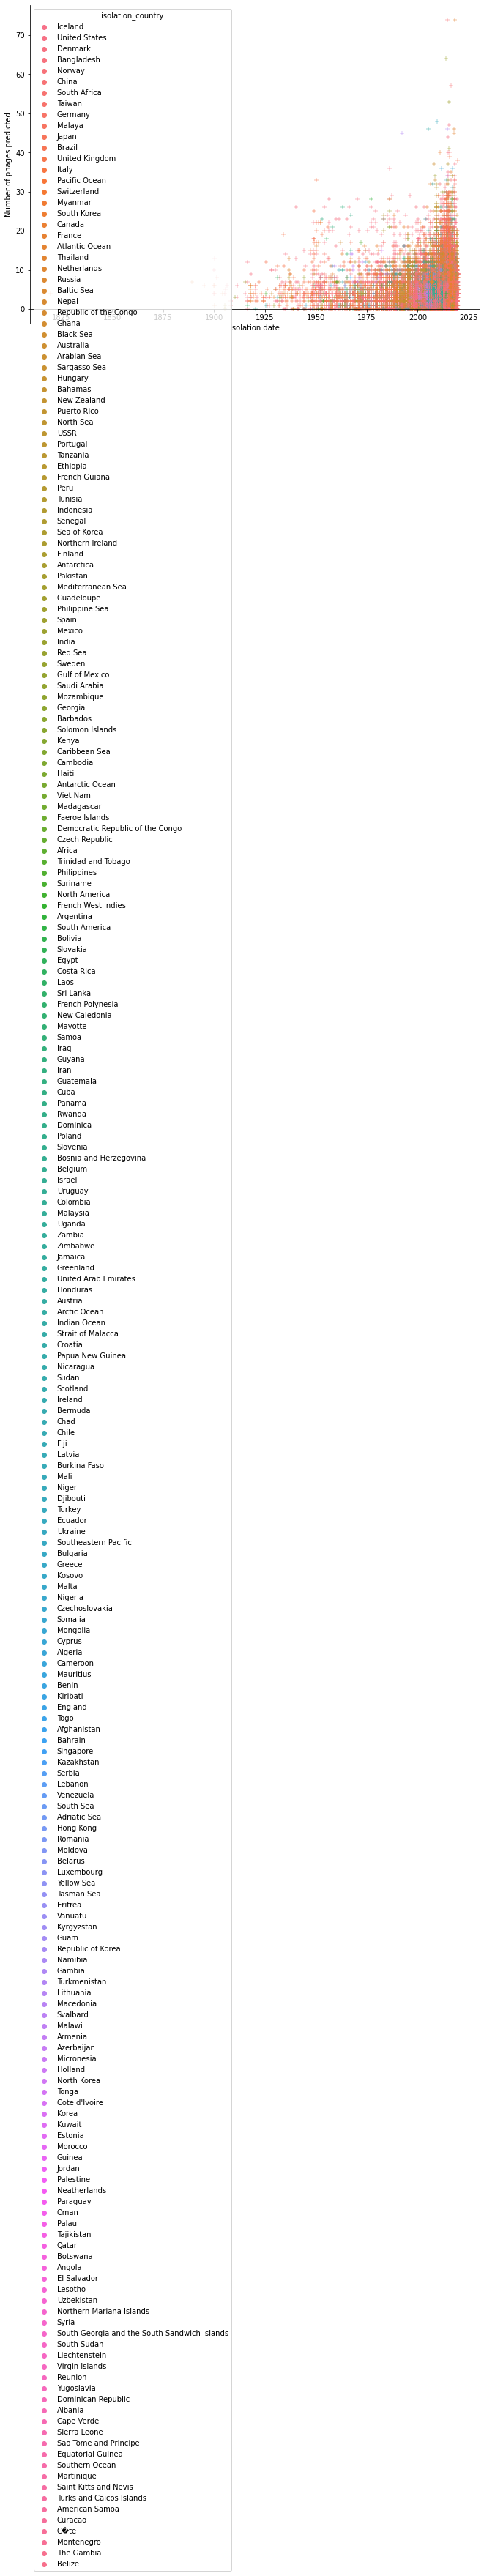

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='isolation_date', y='Kept', data=phagemeta[phagemeta['isolation_date'] != -1], hue=phagemeta['isolation_country'], ax=ax, marker='+', color='k')
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation date")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


## Isolation Country

Here we look at isolation country. Note that earlier we fixed a few countries (e.g. USA -> United States), etc.

Note that we have kept true zero counts: these are genomes for which we have no prophages isolated

In [25]:
phagemeta[(phagemeta['isolation_country'] == 'United States') & (phagemeta['Kept'] == 0)][['assembly_accession', 'Kept']]

,assembly_accession,Kept
5,GCA_000006155.2,0
57,GCA_000007865.1,0
79,GCA_000008465.1,0
88,GCA_000008745.1,0
90,GCA_000008785.1,0
...,...,...
552746,GCA_902728255.1,0
553037,GCA_902859695.1,0
553041,GCA_902859735.1,0
553048,GCA_902859825.1,0


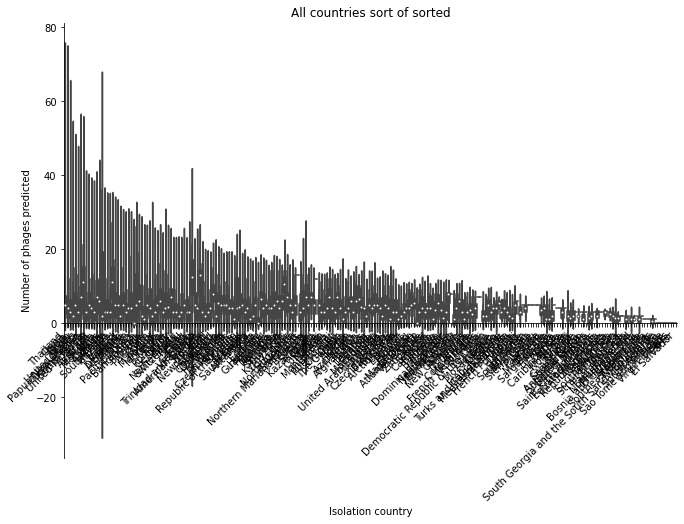

In [26]:
tmp = phagemeta[phagemeta['isolation_country'].notnull()].sort_values('Kept', ascending=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks(rotation=45,  horizontalalignment='right')
ax.set_title('All countries sort of sorted')
fig.savefig(f"images/phages_vs_country_all.svg")

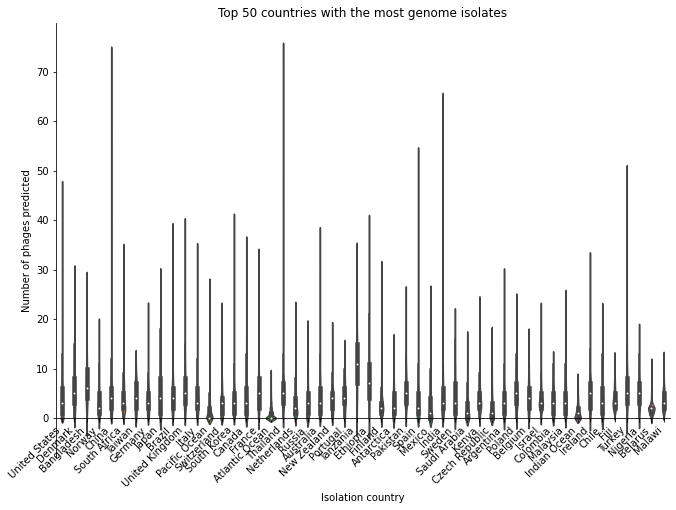

In [27]:
topnc = 50
tmp = phagemeta[phagemeta['isolation_country'].isin(phagemeta.groupby('isolation_country').count().sort_values('assembly_accession', ascending=False).head(topnc).index)]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} countries with the most genome isolates')
plt.xticks(rotation=45,  horizontalalignment='right')

fig.savefig(f"images/phages_vs_country_top.svg")

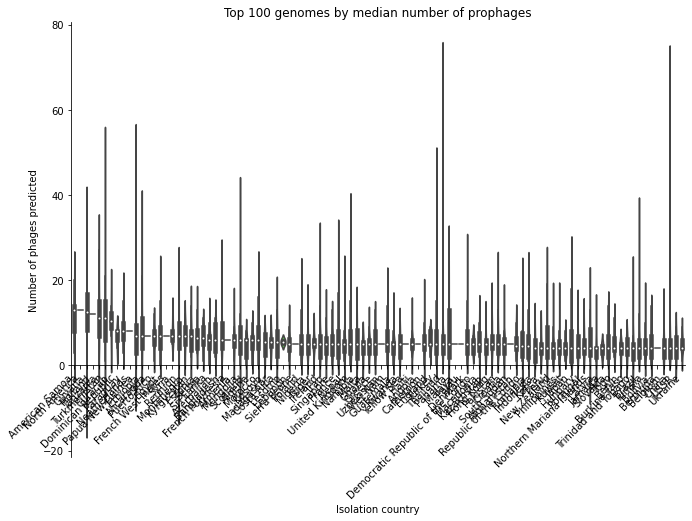

In [28]:
topnc = 100
tmp = phagemeta[phagemeta['isolation_country'].notnull()].sort_values('Kept', ascending=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = phagemeta.groupby('isolation_country')["Kept"].median().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} genomes by median number of prophages')
plt.xticks(rotation=45,  horizontalalignment='right')

fig.savefig(f"images/phages_vs_country_100_median.svg")

In [23]:
topnc=50
phagemeta.groupby('isolation_country')["Kept"].median().sort_values(ascending=False).index[0:topnc]

Index(['American Samoa', 'North America', 'Guyana', 'Holland', 'Tanzania',
       'Turkmenistan', 'Curacao', 'Dominican Republic', 'Paraguay',
       'Neatherlands', 'Papua New Guinea', 'Ethiopia', 'Nicaragua',
       'Puerto Rico', 'Egypt', 'French West Indies', 'Syria', 'Reunion',
       'Montenegro', 'Kyrgyzstan', 'Estonia', 'Serbia', 'Sri Lanka',
       'Azerbaijan', 'Bangladesh', 'French Polynesia', 'Armenia', 'Mongolia',
       'Scotland', 'Algeria', 'Morocco', 'Kosovo', 'Madagascar', 'Costa Rica',
       'Lesotho', 'Lebanon', 'Sierra Leone', 'Poland', 'Nigeria', 'Niger',
       'Ireland', 'Iraq', 'Singapore', 'France', 'Nepal', 'United Kingdom',
       'Namibia', 'Malta', 'Ghana', 'Greece'],
      dtype='object', name='isolation_country')

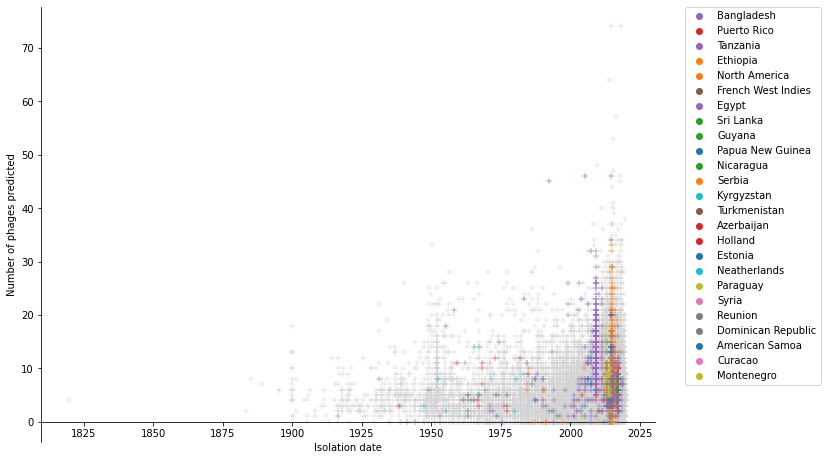

In [66]:
topnc=25
wanted = phagemeta.groupby('isolation_country')["Kept"].median().sort_values(ascending=False).index[0:topnc]
palette = dict(zip(wanted, sns.color_palette(n_colors=len(wanted))))
palette.update({"Other": "lightgrey"})

# we want other to be light grey and in the background
tmpother = phagemeta[~phagemeta['isolation_country'].isin(wanted)]
# we want these to be coloured and on top
tmpwant = phagemeta[phagemeta['isolation_country'].isin(wanted)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))

ax = sns.scatterplot(x='isolation_date', y='Kept', data=tmpother[tmpother['isolation_date'] != -1], color='lightgrey', ax=ax, marker='+', zorder=-5)
ax = sns.scatterplot(x='isolation_date', y='Kept', data=tmpwant[tmpwant['isolation_date'] != -1], hue=tmpwant['isolation_country'], ax=ax, marker='+', palette=palette, zorder=10)

ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation date")
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.savefig(f"images/top_{topnc}_median_genomes_by_year.svg")

In [64]:
phagemeta.groupby('isolation_country')["Kept"].std().sort_values(ascending=False)

isolation_country
Cyprus                  19.924859
Guyana                  12.020815
Turkmenistan            10.275119
Papua New Guinea        10.272082
Reunion                  8.485281
                          ...    
South Sudan                   NaN
Southeastern Pacific          NaN
Strait of Malacca             NaN
Tasman Sea                    NaN
Virgin Islands                NaN
Name: Kept, Length: 232, dtype: float64

In [40]:
phagemeta

,assembly_accession,isolation_site,isolation_country,latitude,longitude,altitude,depth,other_environmental,host_name,host_gender,...,Name,Contig,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Human, Homo sapiens",NaN,...,ASM313v1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,114,10,16,2,1,13,48916
1,GCA_000003645.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ASM364v1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,1,31,1,10,20,40297
2,GCA_000003925.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ASM392v1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,1,38,6,13,19,268081
3,GCA_000003955.1,NaN,Iceland,NaN,NaN,NaN,NaN,NaN,"Human, Homo sapiens",NaN,...,ASM395v1,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,1,46,6,11,29,166286
4,GCA_000005825.2,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ASM582v2,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,3,33,3,9,21,93416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553077,GCA_902860175.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LMG_5997,GCA_902860175.1_LMG_5997_genomic.gbff.gz,7197255,38,21,33,2,14,17,69051
553078,GCA_902860185.1,NaN,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LMG_6103,GCA_902860185.1_LMG_6103_genomic.gbff.gz,6497464,13,8,22,0,10,12,0
553079,GCA_902860195.1,NaN,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LMG_7053,GCA_902860195.1_LMG_7053_genomic.gbff.gz,6702936,200,148,33,1,11,21,12819
553080,GCA_902860205.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LMG_6001,GCA_902860205.1_LMG_6001_genomic.gbff.gz,6320373,36,19,35,2,21,12,41572


In [33]:
pd.unique(phagemeta['isolation_country']).shape

(51,)

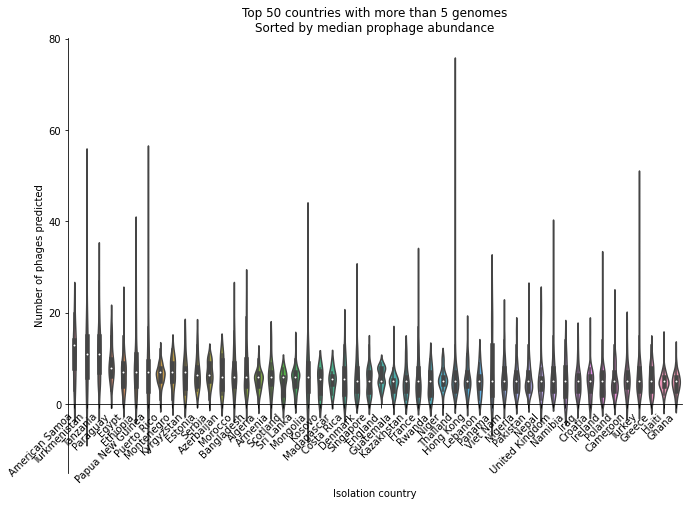

In [30]:
topnc = 50
genomen = 5 
tmpc = pd.DataFrame(phagemeta.groupby('isolation_country').count()['assembly_accession'] > genomen)
tmpc[tmpc['assembly_accession']].index
tmp = phagemeta[phagemeta['isolation_country'].isin(tmpc[tmpc['assembly_accession']].index)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = tmp.groupby('isolation_country')["Kept"].median().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} countries with more than {genomen} genomes\nSorted by median prophage abundance')
plt.xticks(rotation=45,  horizontalalignment='right')

fig.savefig(f"images/phages_vs_country_{topnc}_genomes_{genomen}_phages_median.svg")

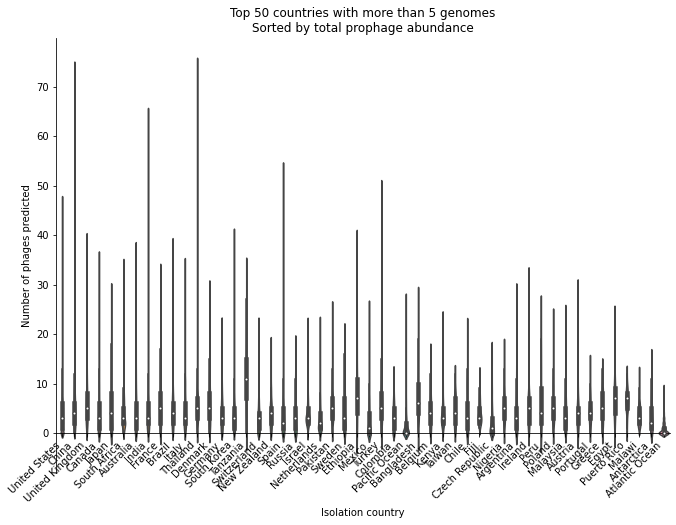

In [31]:
topnc = 50
genomen = 5 
tmpc = pd.DataFrame(phagemeta.groupby('isolation_country').count()['assembly_accession'] > genomen)
tmpc[tmpc['assembly_accession']].index
tmp = phagemeta[phagemeta['isolation_country'].isin(tmpc[tmpc['assembly_accession']].index)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = tmp.groupby('isolation_country')["Kept"].sum().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} countries with more than {genomen} genomes\nSorted by total prophage abundance')
plt.xticks(rotation=45,  horizontalalignment='right')

fig.savefig(f"images/phages_vs_country_{topnc}_genomes_{genomen}_phages_sum.svg")

## Host Name

This is generally where the bacteria was isolated from

In [32]:
pd.unique(phagemeta[phagemeta['host_name'].notnull()]['host_name'])

array(['Human, Homo sapiens', 'Chicken, Gallus gallus',
       'Sugarcane, Saccharum officinarum', ..., 'Olavius algarvensis',
       'Danaus chrysippus', 'Chenopodium quinoa'], dtype=object)

In [33]:
phagemeta.groupby('host_name').count().sort_values('assembly_accession',ascending=False).head(50)

,assembly_accession,isolation_site,isolation_country,latitude,longitude,altitude,depth,other_environmental,host_gender,host_age,...,Name,Contig,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
host_name,,,,,,,,,,,,,,,,,,,,,
"Human, Homo sapiens",41289,128,38152,2878,2877,28,11,637,3390,3266,...,41289,41289,41289,41289,41289,41289,41289,41289,41289,41289
"Cow, Bos taurus",3074,0,2929,0,0,11,30,47,478,9,...,3074,3074,3074,3074,3074,3074,3074,3074,3074,3074
"Chicken, Gallus gallus",1379,0,1213,0,0,6,4,143,2,9,...,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379
"Pig, Sus scrofa",899,0,839,0,0,3,0,18,3,4,...,899,899,899,899,899,899,899,899,899,899
"Chickpea, Cicer arietinum",692,0,690,0,0,327,0,1,0,0,...,692,692,692,692,692,692,692,692,692,692
Ircinia ramosa,509,0,509,0,0,0,0,0,0,0,...,509,509,509,509,509,509,509,509,509,509
"Maize, Zea mays",494,0,489,0,0,0,0,1,0,0,...,494,494,494,494,494,494,494,494,494,494
"Dog, Canis lupus familiaris",465,0,433,0,0,1,1,5,6,7,...,465,465,465,465,465,465,465,465,465,465
"Mouse, Mus musculus",416,0,395,0,0,0,0,60,11,52,...,416,416,416,416,416,416,416,416,416,416


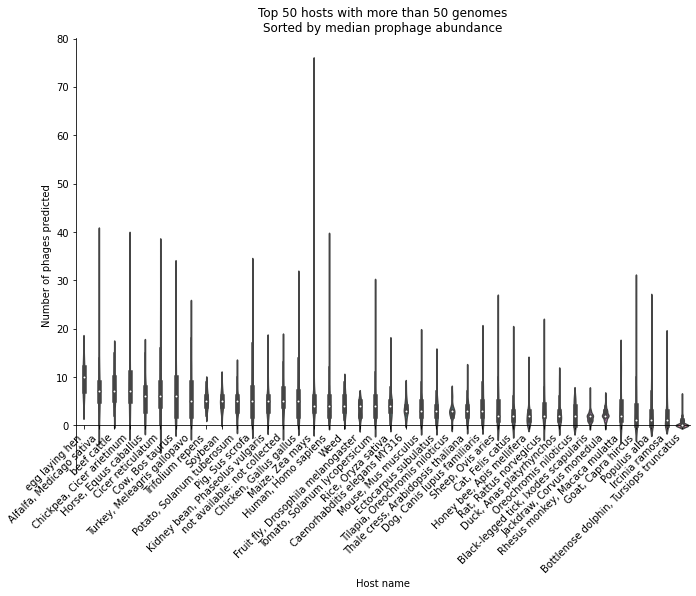

In [34]:
topnc = 50
hostn = 50 
tmpc = pd.DataFrame(phagemeta.groupby('host_name').count()['assembly_accession'] > hostn)
tmp = phagemeta[phagemeta['host_name'].isin(tmpc[tmpc['assembly_accession']].index)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = tmp.groupby('host_name')["Kept"].median().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='host_name', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Host name")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} hosts with more than {hostn} genomes\nSorted by median prophage abundance')
plt.xticks(rotation=45,  horizontalalignment='right')

fig.savefig(f"images/phages_vs_host_{topnc}_genomes_{genomen}_phages_median.svg")

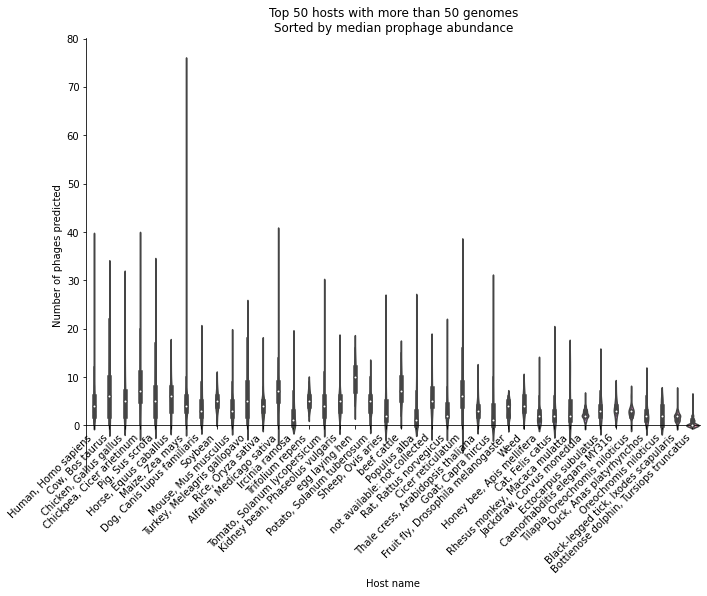

In [35]:
topnc = 50
hostn = 50 
tmpc = pd.DataFrame(phagemeta.groupby('host_name').count()['assembly_accession'] > hostn)
tmp = phagemeta[phagemeta['host_name'].isin(tmpc[tmpc['assembly_accession']].index)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = tmp.groupby('host_name')["Kept"].sum().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='host_name', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Host name")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} hosts with more than {hostn} genomes\nSorted by median prophage abundance')
plt.xticks(rotation=45,  horizontalalignment='right')

fig.savefig(f"images/phages_vs_host_{topnc}_genomes_{genomen}_phages_median.svg")

In [36]:
phagemeta[phagemeta['host_name'] == 'Portulaca grandiflora']

,assembly_accession,isolation_site,isolation_country,latitude,longitude,altitude,depth,other_environmental,host_name,host_gender,...,Name,Contig,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
364392,GCA_009864965.1,NaN,United States,NaN,NaN,NaN,NaN,NaN,Portulaca grandiflora,NaN,...,ASM986496v1,GCA_009864965.1_ASM986496v1_genomic.gbff.gz,7882434,3137,407,284,40,171,73,363661


### the goal!!

Make a plot of importance of each country against {mean, median, stdev, total number} of prophages to understand what is important in driving countries